# 1. Import libraries

In [36]:
import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import eda_helper_functions

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.ensemble import IsolationForest

# 2. Read the Training Data

In [8]:
file_path = r"D:\flight-price-pred-sagemaker\data\train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-06-27,Delhi,Cochin,05:15:00,07:40:00,1585,3,No Info,11543
1,Spicejet,2019-03-09,Chennai,Kolkata,17:45:00,20:05:00,140,0,No Info,6300
2,Air India,2019-03-27,Delhi,Cochin,07:00:00,19:15:00,735,2,No Info,10913
3,Jet Airways,2019-05-15,Kolkata,Banglore,17:00:00,21:05:00,1685,1,No Info,14151
4,Air India,2019-03-24,Banglore,New Delhi,21:10:00,23:55:00,165,0,No Info,4441
...,...,...,...,...,...,...,...,...,...,...
6395,Multiple Carriers,2019-05-21,Delhi,Cochin,11:25:00,19:00:00,455,1,No Info,9103
6396,Indigo,2019-03-15,Banglore,New Delhi,20:00:00,22:55:00,175,0,No Info,8855
6397,Spicejet,2019-03-21,Chennai,Kolkata,17:45:00,20:05:00,140,0,No check-in baggage included,3332
6398,Air India,2019-05-09,Delhi,Cochin,20:15:00,19:15:00,1380,2,No Info,13591


In [9]:
train.dtypes

airline            object
date_of_journey    object
source             object
destination        object
dep_time           object
arrival_time       object
duration            int64
total_stops         int64
additional_info    object
price               int64
dtype: object

In [18]:
train = train.assign(**{
    col : pd.to_datetime(train.loc[:, col], dayfirst = True)
    for col in ["date_of_journey", "dep_time", "arrival_time"]
}  
)

In [19]:
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops                 int64
additional_info            object
price                       int64
dtype: object

In [20]:
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-06-27,Delhi,Cochin,2024-04-28 05:15:00,2024-04-28 07:40:00,1585,3,No Info,11543
1,Spicejet,2019-03-09,Chennai,Kolkata,2024-04-28 17:45:00,2024-04-28 20:05:00,140,0,No Info,6300
2,Air India,2019-03-27,Delhi,Cochin,2024-04-28 07:00:00,2024-04-28 19:15:00,735,2,No Info,10913
3,Jet Airways,2019-05-15,Kolkata,Banglore,2024-04-28 17:00:00,2024-04-28 21:05:00,1685,1,No Info,14151
4,Air India,2019-03-24,Banglore,New Delhi,2024-04-28 21:10:00,2024-04-28 23:55:00,165,0,No Info,4441


# 3. High Level Summary

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          6400 non-null   object        
 1   date_of_journey  6400 non-null   datetime64[ns]
 2   source           6400 non-null   object        
 3   destination      6400 non-null   object        
 4   dep_time         6400 non-null   datetime64[ns]
 5   arrival_time     6400 non-null   datetime64[ns]
 6   duration         6400 non-null   int64         
 7   total_stops      6400 non-null   int64         
 8   additional_info  6400 non-null   object        
 9   price            6400 non-null   int64         
dtypes: datetime64[ns](3), int64(3), object(4)
memory usage: 500.1+ KB


In [24]:
train.describe(include = "number")

,duration,total_stops,price
count,6400.000000,6400.000000,6400.000000
mean,631.817188,0.802969,9023.592344
std,501.489509,0.660372,4621.645889
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5228.000000
50%,505.000000,1.000000,8269.500000
75%,910.000000,1.000000,12305.750000
max,2860.000000,4.000000,79512.000000


In [25]:
train.describe(include = "O")

,airline,source,destination,additional_info
count,6400,6400,6400,6400
unique,8,5,6,8
top,Jet Airways,Delhi,Cochin,No Info
freq,2290,2650,2650,4978


In [27]:
(
    train
    .assign(total_stops = train["total_stops"].astype(object))
    .describe(include = "O")
)

,airline,source,destination,total_stops,additional_info
count,6400,6400,6400,6400,6400
unique,8,5,6,5,8
top,Jet Airways,Delhi,Cochin,1,No Info
freq,2290,2650,2650,3444,4978


# 4. High-level Analysis of Missing Values

In [29]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


- No missing values present in the data set

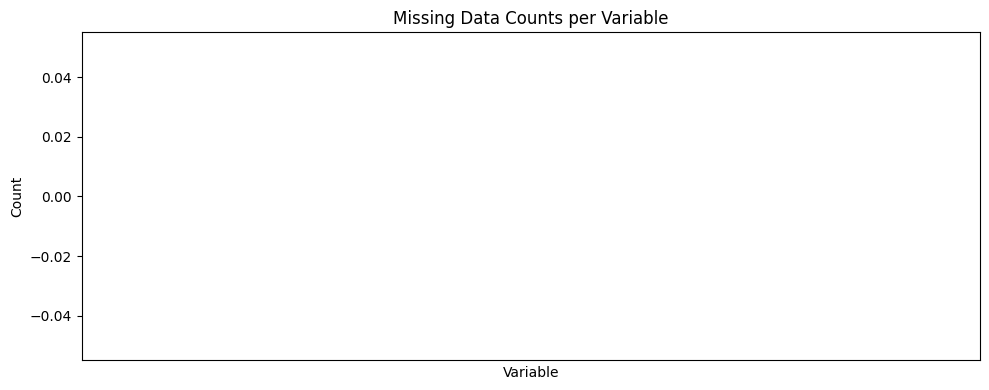

In [30]:
eda_helper_functions.plot_missing_info(train)

In [32]:
# We can use this also for validating missing number in dataset

# import missingno as msno
# %matplotlib inline
# msno.matrix(collisions.sample(250))

# 5. High Level Analysis of Outliers

In [37]:
forest = IsolationForest(n_estimators = 10, random_state = 42)

In [44]:
(
    train
    .assign(outlier = forest.fit_predict(train
                                              .drop(columns = "price")
                                              .select_dtypes(include = "number")))
    .query("outlier == -1")
    # .duration
    # .describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
0,Air India,2019-06-27,Delhi,Cochin,2024-04-28 05:15:00,2024-04-28 07:40:00,1585,3,No Info,11543,-1
1,Spicejet,2019-03-09,Chennai,Kolkata,2024-04-28 17:45:00,2024-04-28 20:05:00,140,0,No Info,6300,-1
2,Air India,2019-03-27,Delhi,Cochin,2024-04-28 07:00:00,2024-04-28 19:15:00,735,2,No Info,10913,-1
3,Jet Airways,2019-05-15,Kolkata,Banglore,2024-04-28 17:00:00,2024-04-28 21:05:00,1685,1,No Info,14151,-1
5,Spicejet,2019-06-09,Chennai,Kolkata,2024-04-28 17:45:00,2024-04-28 20:05:00,140,0,No Info,3597,-1
...,...,...,...,...,...,...,...,...,...,...,...
6384,Air India,2019-05-15,Delhi,Cochin,2024-04-28 14:10:00,2024-04-28 17:10:00,180,0,No Info,6094,-1
6385,Air India,2019-05-12,Kolkata,Banglore,2024-04-28 09:25:00,2024-04-28 05:35:00,1210,2,No Info,11432,-1
6392,Jet Airways,2019-05-27,Delhi,Cochin,2024-04-28 19:30:00,2024-04-28 04:25:00,535,2,No Info,15129,-1
6397,Spicejet,2019-03-21,Chennai,Kolkata,2024-04-28 17:45:00,2024-04-28 20:05:00,140,0,No check-in baggage included,3332,-1


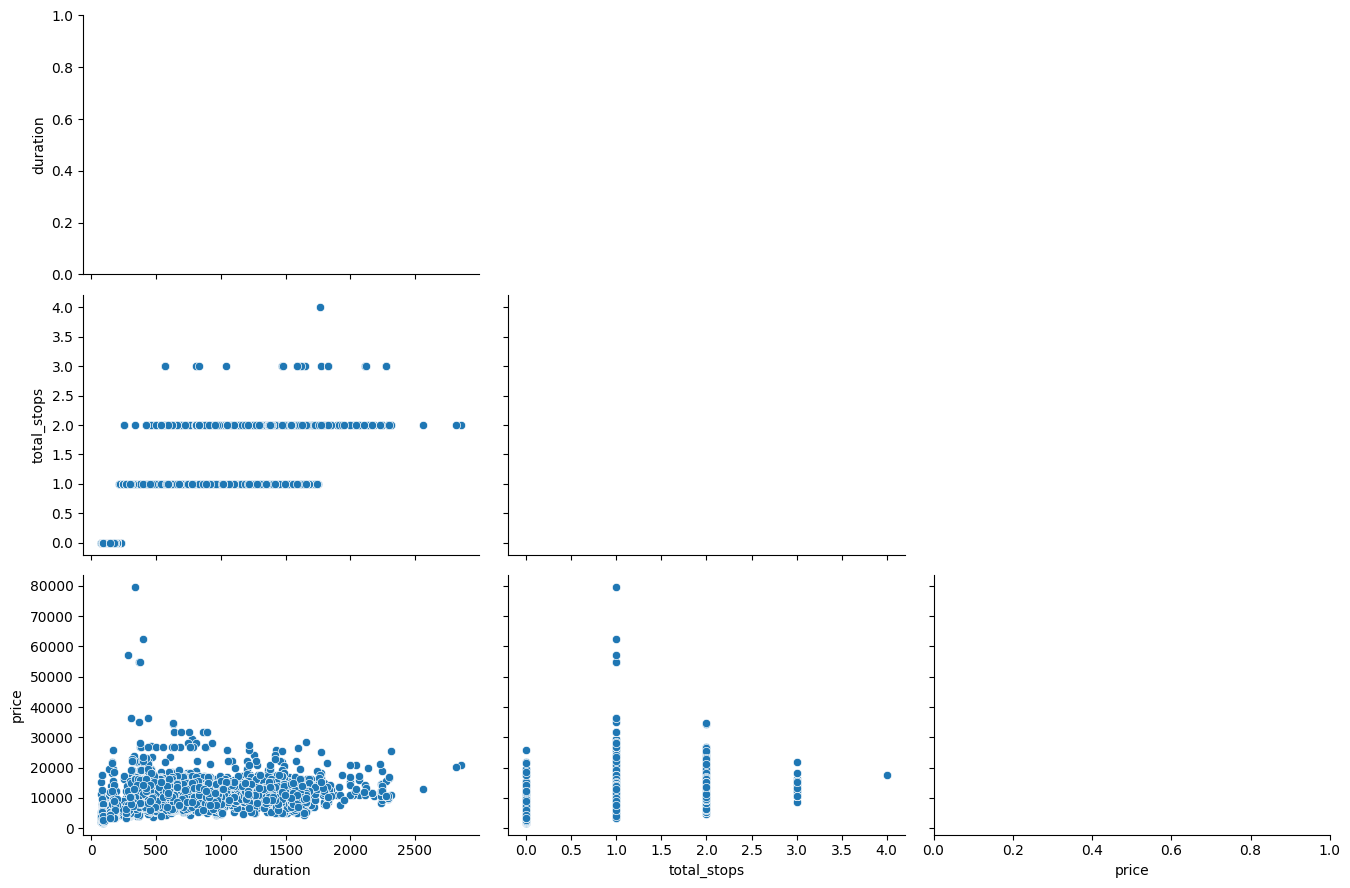

In [45]:
eda_helper_functions.pair_plots(train)

# 7. Correlation Analysis

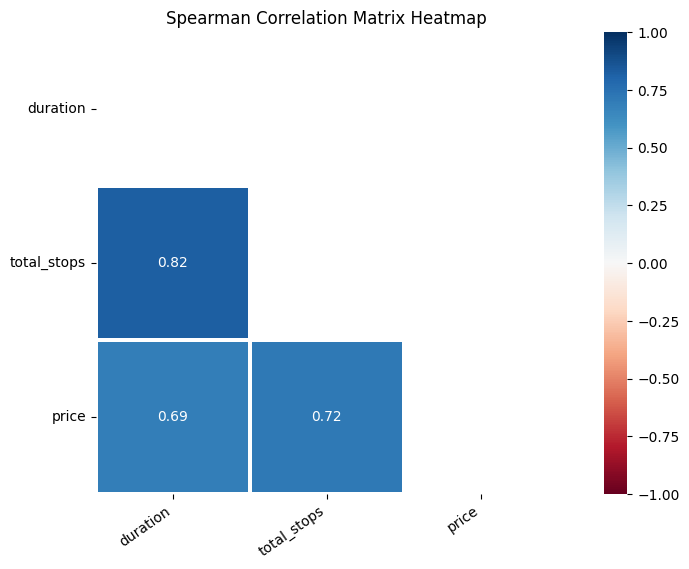

In [46]:
eda_helper_functions.correlation_heatmap(train)

- So we can't used linear based model so we will choose Tree based model for this.

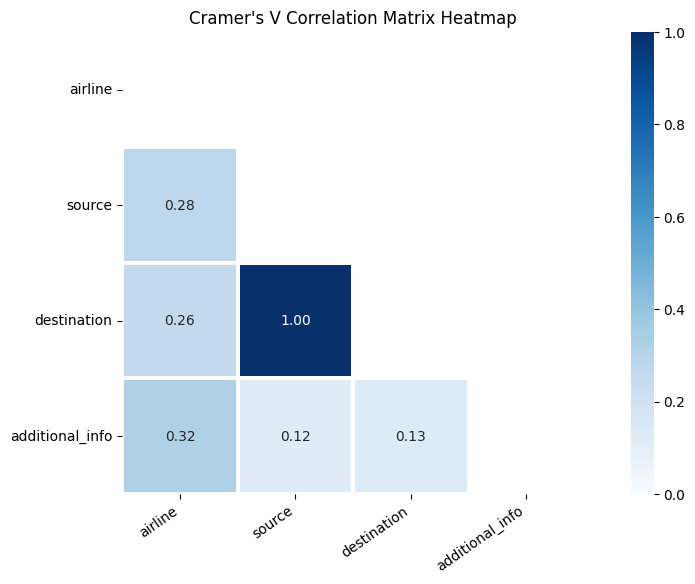

In [48]:
eda_helper_functions.cramersV_heatmap(train)